In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from finance.utilities import utils, financial_utils, time_series_utils

## Stocks

In [2]:
query = """
    select 
        e.symbol
        , e.market_datetime
        , e.open
        , e.high
        , e.low
        , e.close
        , e.volume
        , f.high_52
        , f.low_52
        , f.dividend_amount
        , f.pe_ratio
        , f.quick_ratio
        , f.current_ratio
    from td.equities as e
    left join td.fundamentals as f 
        on f.symbol = e.symbol
    where e.symbol = 'BA'
    order by e.market_datetime
    """

df = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)
df.head()

,symbol,market_datetime,open,high,low,close,volume,high_52,low_52,dividend_amount,pe_ratio,quick_ratio,current_ratio
0,BA,1999-09-03 05:00:00,45.1875,45.6250,45.1875,45.4375,2191300.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
1,BA,1999-09-07 05:00:00,45.4375,45.6250,44.8750,44.9375,1906600.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
2,BA,1999-09-08 05:00:00,44.8125,44.8125,44.3125,44.5625,2095200.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
3,BA,1999-09-09 05:00:00,44.5625,45.2500,44.3750,45.1250,2109000.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
4,BA,1999-09-10 05:00:00,45.1250,45.7500,44.8750,45.2500,1724900.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317


### Time series

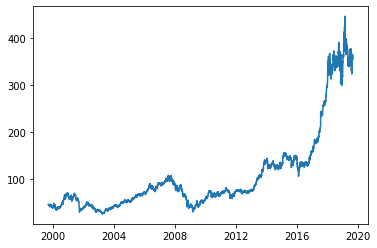

In [3]:
plt.plot(df['market_datetime'], df['open'])
plt.show()

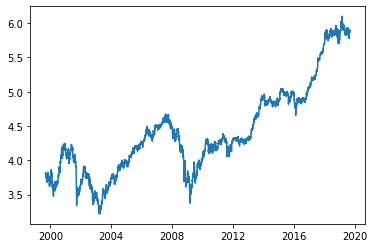

In [4]:
plt.plot(df['market_datetime'], np.log(df['open']))
plt.show()

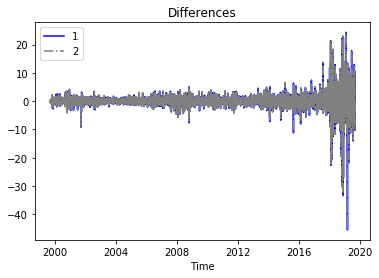

In [5]:
time_series_utils.ARIMA(series=df['open'], datetimes=df['market_datetime']).differences_plot()

/Users/rickbetzler/anaconda3/envs/babylon/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/rickbetzler/anaconda3/envs/babylon/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/rickbetzler/anaconda3/envs/babylon/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


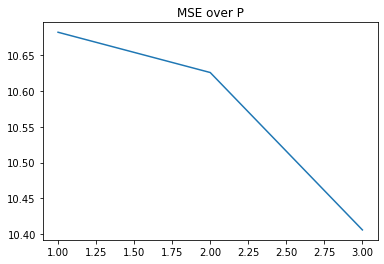

In [6]:
time_series_utils.ARIMA(series=df['open'],
          datetimes=df['market_datetime'], p=(1,4), d=(0,1), q=(0,1),
          forecast_date=('2019-08-05', '2019-08-09')).benchmark_plot()

### Time series metrics

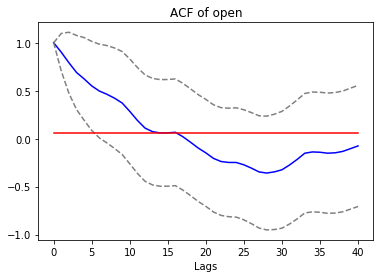

In [6]:
time_series_utils.ARIMA(series=df['open']).acf_plot()

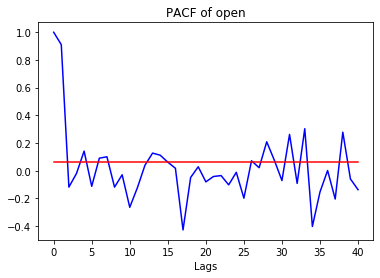

In [7]:
time_series_utils.ARIMA(series=df['open']).pacf_plot()

### ARIMA 

In [8]:
time_series_utils.ARIMA(series=df['open'], 
                        datetimes=df['market_datetime'], 
                        forecast_date='2019-08-08').model_forecast

{'forecast': 328.9383395540727,
 'aic': 23967.31809120681,
 'bic': 23993.542208067614}

In [9]:
time_series_utils.ARIMA(series=df['open'],
                        datetimes=df['market_datetime'],
                        p=3, d=2, forecast_date='2019-09-02').optimal_params

,,,aic,bic,forecast,actual,mse,mae
p,d,q,,,,,,
2,0,0,24153.236195,24179.474139,364.321438,354.11,104.273462,10.211438


### ML on Prices

In [39]:
full = df.tail(1000)
train = full.head(900)
test = df.tail(100)

In [40]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train['open'].values.reshape(-1,1))
nbrs.kneighbors(train['open'].values.reshape(-1,1))

(array([[0.  , 0.  ],
        [0.  , 0.02],
        [0.  , 0.03],
        ...,
        [0.  , 0.32],
        [0.  , 0.08],
        [0.  , 0.  ]]), array([[235,   0],
        [  1, 236],
        [  2, 157],
        ...,
        [897, 891],
        [898, 798],
        [766, 899]]))

In [85]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=10, random_state=0).fit(train['open'].values.reshape(-1,1))
preds = cluster.predict(test['open'].values.reshape(-1,1))
cluster.cluster_centers_

array([[334.65497027],
       [151.3370264 ],
       [236.8425641 ],
       [129.87729487],
       [375.45546296],
       [302.19828571],
       [354.82162162],
       [186.10585138],
       [418.77791667],
       [261.70982759]])

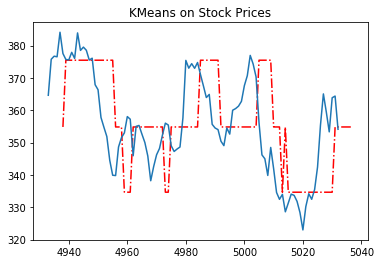

In [89]:
# Need to show how this looks when actually iter across days
plt.figure()
plt.title('KMeans on Stock Prices')
plt.plot(test.index.values+5, cluster.cluster_centers_[preds], color='r', linestyle='-.')
plt.plot(test['open'])
plt.show()